# Model Development

Develop the model artifact using Catboost Boost

### Import Libraries and Path

Libraries

In [1]:
import os

import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
import numpy as np
import catboost as cb

print("NumPy version:", np.__version__)
print("CatBoost version:", cb.__version__)


NumPy version: 1.24.4
CatBoost version: 1.2.5


Data path

In [3]:
data_path_in  = "C:/Users/Ahmed/OneDrive/Documents/projects/procore/01_data/inbound/"
data_path_out = "C:/Users/Ahmed/OneDrive/Documents/projects/procore/01_data/outbound/"

In [4]:
function_path = "C:/Users/Ahmed/OneDrive/Documents/projects/procore/06_functions/"

### Load Data

In [5]:
cbm_train = pd.read_parquet(data_path_out + 'catboost/train.parquet')
cbm_test  = pd.read_parquet(data_path_out + 'catboost/test.parquet')

print("cbm_train shape:", cbm_train.shape)
print("cbm_test shape:", cbm_test.shape)

cbm_train shape: (1500, 60)
cbm_test shape: (500, 60)


In [6]:
# Calculate the exact number of rows to sample (10%)
train_sample_size = int(0.10 * len(cbm_train))
test_sample_size = int(0.10 * len(cbm_test))

# Sample 10% of the data from both train and test sets
cbm_train_sample = cbm_train.sample(n=train_sample_size, random_state=42)
cbm_test_sample = cbm_test.sample(n=test_sample_size, random_state=42)

# Combine these samples to create the OOT dataset
cbm_oot = pd.concat([cbm_train_sample, cbm_test_sample])

# Remove the sampled data from the original datasets
cbm_train = cbm_train.drop(cbm_train_sample.index)
cbm_test = cbm_test.drop(cbm_test_sample.index)

# Print the shapes of the datasets to confirm
print("cbm_train shape after split:\t", cbm_train.shape)
print("cbm_test shape after split:\t", cbm_test.shape)
print("cbm_oot shape:\t\t\t", cbm_oot.shape)


cbm_train shape after split:	 (1350, 60)
cbm_test shape after split:	 (450, 60)
cbm_oot shape:			 (200, 60)


### Organize features

Organize features to numerical, categorical, target, drop features

In [7]:
drop_features = ['zipcode', 'price']  

numerical_features = cbm_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = [feature for feature in numerical_features if feature not in drop_features]

categorical_features = cbm_train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features = [feature for feature in categorical_features if feature not in drop_features]

target = ['price']

print("drop_features:\t\t", len(drop_features))
print("numerical_features:\t", len(numerical_features))
print("categorical_features:\t", len(categorical_features))
print("target:\t\t\t", len(target))

drop_features:		 2
numerical_features:	 28
categorical_features:	 30
target:			 1


In [8]:
X_train = cbm_train[numerical_features + categorical_features]
y_train = cbm_train[target]

X_test = cbm_test[numerical_features + categorical_features]
y_test = cbm_test[target] 

X_oot = cbm_oot[numerical_features + categorical_features]
y_oot = cbm_oot[target] 

### Fit Catboost Model 

In [9]:
# param_grid = {
param_dist = {
    'iterations': [50, 150, 500],           # Number of boosting iterations
    'depth': [2, 3, 4],                     # step size at each iteration
    'learning_rate': [0.01, 0.05, 0.1],     # depth of the trees
    'l2_leaf_reg': [1, 3, 5],               # penalizing large weights in the model
    'bagging_temperature': [0.0, 0.5, 1.0], # controls the randomness
    'subsample': [0.6, 0.8, 1.0],           #  samples to be used for fitting each individual tree
    'colsample_bylevel': [0.6, 0.8, 1.0],   # features to be randomly selected at each level of the tree
    'random_strength': [0.0, 1.0, 2.0],     # amount of randomness in the model
}

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor

# Define the model
catboost_model = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    logging_level='Silent'
)

# Perform the search (updated)
random_search = RandomizedSearchCV(
    catboost_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1,  # Use all cores
    random_state=42
)

# Perform the search
random_search.fit(X_train, y_train, cat_features=categorical_features)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.8, 'random_strength': 0.0, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 2, 'colsample_bylevel': 0.6, 'bagging_temperature': 1.0}


In [11]:
# best_params = grid_search.best_params_

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize the CatBoost model
catboost_model = CatBoostRegressor(
    iterations=500,             # Number of boosting iterations
    learning_rate=0.01,         # Learning rate
    depth=2,                    # Depth of the trees
    loss_function='RMSE',       # Loss function to optimize
    random_seed=42,             # For reproducibility
    verbose=100,                # Print training progress every 100 iterations
    subsample=1.0,              # Subsample ratio of the training instances
    random_strength=2.0,        # Randomness strength for score calculations
    l2_leaf_reg=2,              # L2 regularization term on weights
    colsample_bylevel=0.5,      # Subsample ratio of columns for each split level
    bagging_temperature=1.0     # Controls the intensity of bagging
)

# Train the model on the training data
catboost_model.fit(X_train, y_train, cat_features=categorical_features, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 139.1302948	test: 162.7168418	best: 162.7168418 (0)	total: 8.02ms	remaining: 4s
100:	learn: 118.4963223	test: 136.4952806	best: 136.4952806 (100)	total: 1.22s	remaining: 4.81s
200:	learn: 109.6691626	test: 126.9644026	best: 126.9644026 (200)	total: 2.42s	remaining: 3.6s
300:	learn: 103.5902619	test: 121.4116698	best: 121.4116698 (300)	total: 3.62s	remaining: 2.4s
400:	learn: 99.5594119	test: 118.2503478	best: 118.2503478 (400)	total: 4.83s	remaining: 1.19s
499:	learn: 96.6140107	test: 116.2555066	best: 116.2555066 (499)	total: 6.06s	remaining: 0us

bestTest = 116.2555066
bestIteration = 499



In [12]:
# Predict on the test data
y_train_pred = catboost_model.predict(X_train)
y_test_pred = catboost_model.predict(X_test)
y_oot_pred = catboost_model.predict(X_oot)

In [13]:
# Evaluate the model on the train data
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate the model on the test data
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Evaluate the model on the OOT data
mse_oot = mean_squared_error(y_oot, y_oot_pred)
rmse_oot = np.sqrt(mse_oot)
r2_oot = r2_score(y_oot, y_oot_pred)

In [14]:
# Create a dictionary with the metrics
metrics_dict = {
    'Dataset': ['Train', 'Test', 'OOT'],
    'RMSE': [rmse_train, rmse_test, rmse_oot],
    'R^2': [r2_train, r2_test, r2_oot]
}

# Convert the dictionary into a DataFrame
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,Dataset,RMSE,R^2
0,Train,99.042034,0.495546
1,Test,116.255507,0.492559
2,OOT,201.895335,0.143916


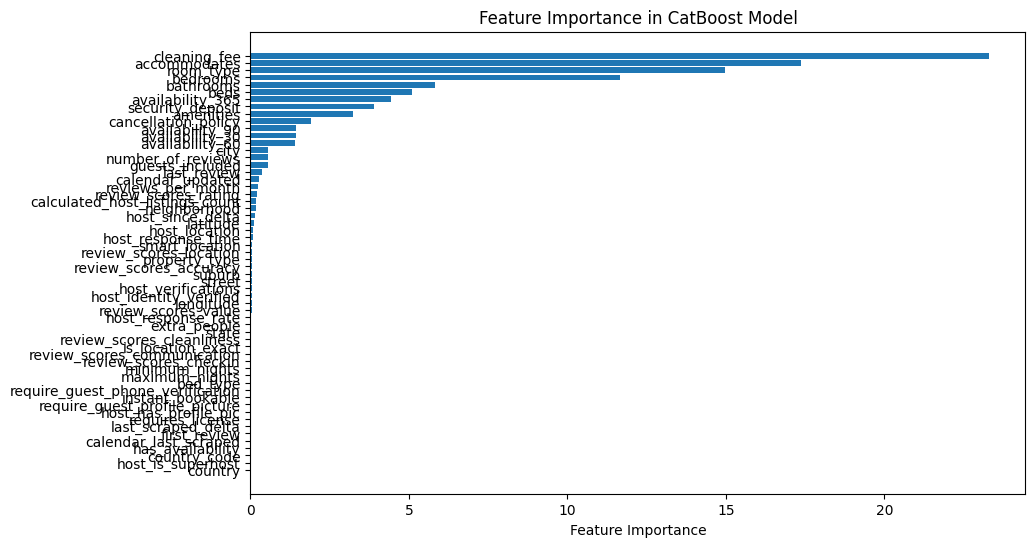

In [15]:
# Plot feature importances
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance
feature_importances = catboost_model.get_feature_importance()

# Match feature importances with feature names
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Feature Importance in CatBoost Model")
plt.show()

#### The objective is to get the train and test samples performances as close as possible while maximizing the OOT performance.
#### The model above, with the specified paramaters accomplishes this

#### Now to ensure maximum performance on the true OOT data, we will retrain the model using the same parameters but combining the train, test and oot data all into the training set. This will allow us to get the most out of our data. 

##### Combine data into big training data

In [16]:
# Combine the train, test, and OOT datasets into one big training set
combined_df = pd.concat([cbm_train, cbm_test, cbm_oot], ignore_index=True)

from sklearn.model_selection import train_test_split

X = combined_df.drop(columns=['price'])  
y = combined_df['price']  

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the shapes to verify the split
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (1600, 59)
X_test shape: (400, 59)
y_train shape: (1600,)
y_test shape: (400,)


In [17]:
# Initialize the catboost model with the specified parameters
catboost_model = CatBoostRegressor(
    iterations=500,             # Number of boosting iterations
    learning_rate=0.01,         # Learning rate
    depth=2,                    # Depth of the trees
    loss_function='RMSE',       # Loss function to optimize
    random_seed=42,             # For reproducibility
    verbose=100,                # Print training progress every 100 iterations
    subsample=1.0,              # Subsample ratio of the training instances
    random_strength=2.0,        # Randomness strength for score calculations
    l2_leaf_reg=2,              # L2 regularization term on weights
    colsample_bylevel=0.5,      # Subsample ratio of columns for each split level
    bagging_temperature=1.0     # Controls the intensity of bagging
)

# Train the model on the training data
catboost_model.fit(X_train, y_train, cat_features=categorical_features, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 155.1617363	test: 151.3312013	best: 151.3312013 (0)	total: 14ms	remaining: 6.97s
100:	learn: 131.9492141	test: 134.3410132	best: 134.3410132 (100)	total: 1.3s	remaining: 5.12s
200:	learn: 121.9878671	test: 127.3696098	best: 127.3696098 (200)	total: 2.49s	remaining: 3.7s
300:	learn: 117.3678584	test: 124.0237415	best: 124.0237415 (300)	total: 3.69s	remaining: 2.44s
400:	learn: 114.2277530	test: 121.9333472	best: 121.9333472 (400)	total: 4.9s	remaining: 1.21s
499:	learn: 111.8239000	test: 120.3683553	best: 120.3683553 (499)	total: 6.1s	remaining: 0us

bestTest = 120.3683553
bestIteration = 499



Save model artifact and perfromance for inference

In [24]:
model_path

'C:/Users/Ahmed/OneDrive/Documents/projects/procore/07_artifacts/catboost_model.cbm'

In [25]:
model_folder = "C:/Users/Ahmed/OneDrive/Documents/projects/procore/07_artifacts/"
model_filename = "catboost_model.cbm"
model_path = os.path.join(model_folder, model_filename)

catboost_model.save_model(model_path)

print("Model saved as catboost_model.cbm")

Model saved as catboost_model.cbm


In [19]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import matplotlib.pyplot as plt

# Define the scoring metrics
scoring = {'rmse': make_scorer(mean_squared_error, squared=False),
           'r2': make_scorer(r2_score)}

# Specify the indices of categorical features, if any
categorical_features_indices = categorical_features

# Perform cross-validation to evaluate the CatBoost model
cv_results = cross_validate(catboost_model, X, y, cv=5, scoring=scoring, fit_params={'cat_features': categorical_features_indices})

# Extract the RMSE and R^2 scores
cv_rmse_scores = cv_results['test_rmse']
cv_r2_scores = cv_results['test_r2']

# Add the cross-validation results to the DataFrame
for i in range(len(cv_rmse_scores)):
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Dataset': [f'CV Fold {i+1}'],
        'RMSE': [cv_rmse_scores[i]],
        'R^2': [cv_r2_scores[i]]
    })], ignore_index=True)

# Add the mean cross-validation scores to the DataFrame
metrics_df = pd.concat([metrics_df, pd.DataFrame({
    'Dataset': ['CV Mean'],
    'RMSE': [np.mean(cv_rmse_scores)],
    'R^2': [np.mean(cv_r2_scores)]
})], ignore_index=True)

# Display the DataFrame
metrics_df

0:	learn: 158.4864078	total: 17ms	remaining: 8.47s
100:	learn: 134.8893025	total: 1.26s	remaining: 4.99s
200:	learn: 124.4185110	total: 2.5s	remaining: 3.72s
300:	learn: 119.3895314	total: 3.73s	remaining: 2.46s
400:	learn: 116.1875182	total: 4.95s	remaining: 1.22s
499:	learn: 113.9577800	total: 6.2s	remaining: 0us
0:	learn: 158.6658358	total: 6.86ms	remaining: 3.42s
100:	learn: 136.2464360	total: 1.23s	remaining: 4.86s
200:	learn: 127.3952316	total: 2.38s	remaining: 3.53s
300:	learn: 122.4901024	total: 3.54s	remaining: 2.34s
400:	learn: 119.4347077	total: 4.69s	remaining: 1.16s
499:	learn: 116.7537822	total: 5.84s	remaining: 0us
0:	learn: 154.0782770	total: 7.13ms	remaining: 3.56s
100:	learn: 134.7481348	total: 1.17s	remaining: 4.62s
200:	learn: 125.4939221	total: 2.25s	remaining: 3.35s
300:	learn: 120.3203041	total: 3.39s	remaining: 2.24s
400:	learn: 116.8912331	total: 4.49s	remaining: 1.11s
499:	learn: 114.4278083	total: 5.59s	remaining: 0us
0:	learn: 155.9595653	total: 7.62ms	remai

,Dataset,RMSE,R^2
0,Train,99.042034,0.495546
1,Test,116.255507,0.492559
2,OOT,201.895335,0.143916
3,CV Fold 1,111.130061,0.342111
4,CV Fold 2,100.622342,0.444492
5,CV Fold 3,106.546684,0.529062
6,CV Fold 4,114.533518,0.401672
7,CV Fold 5,160.668779,0.291452
8,CV Mean,118.700277,0.401758


In [21]:
metrics_df.to_csv(data_path_out + 'catboost/model_performance.csv', index=False)

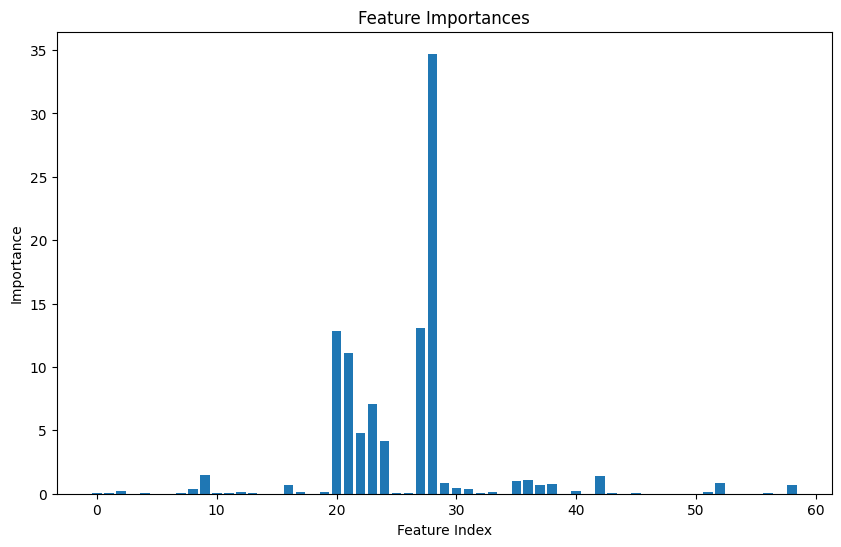

In [22]:
# Plot feature importances
feature_importances = catboost_model.get_feature_importance()
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()